# In Depth: Linear Regression

Точно так же, как наивный байесовский метод (обсуждаемый ранее в разделе [Подробно: наивная байесовская классификация](05.05-Naive-Bayes.ipynb)) является хорошей отправной точкой для задач классификации, модели линейной регрессии являются хорошей отправной точкой для задач регрессии.
Такие модели популярны, потому что их можно очень быстро подобрать и легко интерпретировать.
Вы, вероятно, знакомы с простейшей формой модели линейной регрессии (т. е. подбором прямой линии к данным), но такие модели можно расширить для моделирования более сложного поведения данных.

В этом разделе мы начнем с быстрого интуитивного прохождения математики, стоящей за этой хорошо известной проблемой, прежде чем рассмотрим, как это сделать, прежде чем перейти к рассмотрению того, как можно обобщить линейные модели для учета более сложных закономерностей в данных.

Начнем со стандартного импорта:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Простая линейная регрессия

Мы начнем с наиболее знакомой линейной регрессии, прямолинейной подгонки к данным.
Прямой крой – это модель формы
$$
y = ax + b
$$
где $a$ обычно называют *наклоном*, а $b$ обычно называют *intercept*.

Рассмотрим следующие данные, разбросанные по линии с наклоном 2 и точкой пересечения -5:

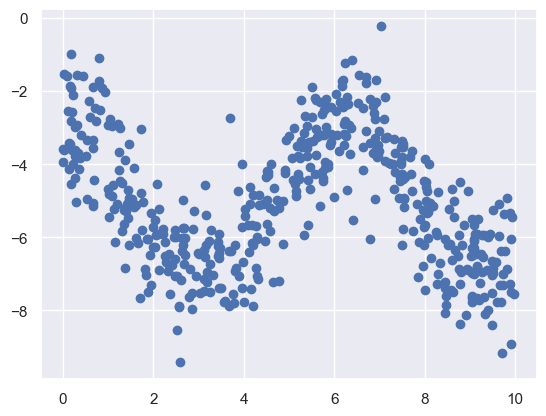

In [39]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(500)
y = 2 * np.cos(x) - 5 + rng.randn(500)
plt.scatter(x, y);

Мы можем использовать оценщик Scikit-Learn ``LinearRegression``, чтобы подобрать эти данные и построить наиболее подходящую линию:

In [24]:
x[0]

4.17022004702574

In [25]:
x[:, np.newaxis].shape

(50, 1)

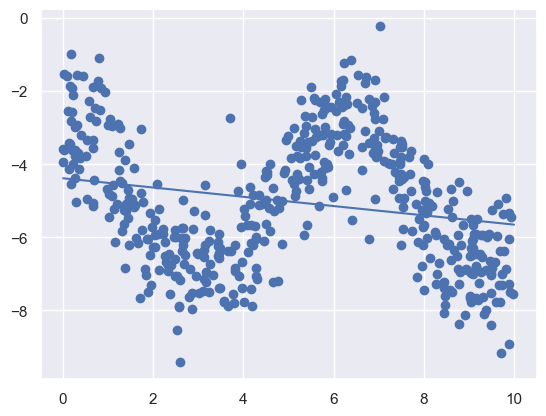

In [40]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [27]:
model.intercept_

-4.995731256659616

In [28]:
model.coef_[0]

2.0816264310820864

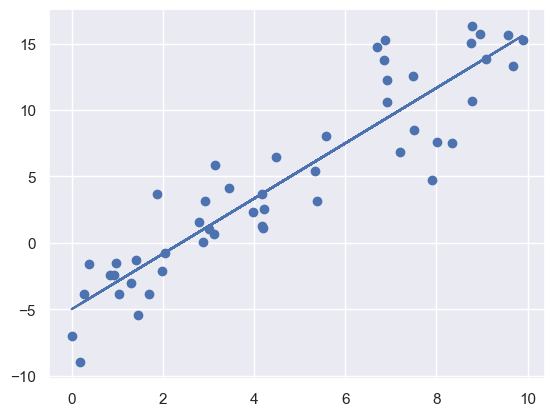

In [29]:
plt.figure()
plt.scatter(x, y)
plt.plot(x, model.coef_[0]*x+model.intercept_)
plt.show()

Наклон и точка пересечения данных содержатся в параметрах подбора модели, которые в Scikit-Learn всегда отмечены завершающим подчеркиванием.
Здесь соответствующими параметрами являются ``coef_`` и ``intercept_``:

In [8]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.0816264310820864
Model intercept: -4.995731256659616


Мы видим, что результаты очень близки к входным данным, как мы и надеемся.

Однако оценщик ``LinearRegression`` обладает гораздо большими возможностями — в дополнение к простой подгонке по прямой, он также может обрабатывать многомерные линейные модели формы
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$
where there are multiple $x$ values.
Геометрически это похоже на подгонку плоскости к точкам в трех измерениях или подгонку гиперплоскости к точкам в более высоких измерениях.

Многомерный характер таких регрессий затрудняет их визуализацию, но мы можем увидеть одно из этих совпадений в действии, создав некоторые примеры данных, используя оператор умножения матриц NumPy:

In [35]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 10.])
print(X.shape)
print(y.shape)

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

(100, 3)
(100,)
0.5000000000000355
[ 1.5 -2.  10. ]


In [40]:
#то есть фактически мы имеем систему уровнений 
#x1*1.5+x2*-2+x3*1=y1 или  x11*w1+x21*w2+x31*w3=y1
#                          x12*w1+x22*w2+x32*w3=y2
#                          ......
#                          x1n*w1+x2n*w2+x3n*w3=yn           

Здесь данные $y$ строятся из трех случайных значений $x$, а линейная регрессия восстанавливает коэффициенты, использованные для построения данных.

Таким образом, мы можем использовать единую оценку LinearRegression для подгонки линий, плоскостей или гиперплоскостей к нашим данным.
По-прежнему кажется, что этот подход будет ограничен строго линейными отношениями между переменными, но оказывается, что мы можем и это ослабить.

## Регрессия базовой функции

Один прием, который вы можете использовать для адаптации линейной регрессии к нелинейным отношениям между переменными, заключается в преобразовании данных в соответствии с *базисными функциями*.
Мы видели одну версию этого раньше, в конвейере «Полиномиальная регрессия», используемом в [Гиперпараметры и проверка модели] (05.03-Hyperparameters-and-Model-Validation.ipynb) и [Разработка функций] (05.04-Разработка функций. ипинб).
Идея состоит в том, чтобы взять нашу многомерную линейную модель:

$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$
и создайте $x_1, x_2, x_3,$ и так далее из нашего одномерного ввода $x$.
То есть мы допускаем $x_n = f_n(x)$, где $f_n()$ — некоторая функция, преобразующая наши данные.

Например, если $f_n(x) = x^n$, наша модель становится полиномиальной регрессией:
$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$
Обратите внимание, что это *по-прежнему линейная модель* — линейность относится к тому факту, что коэффициенты $a_n$ никогда не умножаются и не делятся друг на друга.
Что мы действительно сделали, так это взяли наши одномерные значения $x$ и спроецировали их в более высокое измерение, так что линейная подгонка может соответствовать более сложным отношениям между $x$ и $y$.

### Полиномиальные базисные функции

Эта полиномиальная проекция настолько полезна, что встроена в Scikit-Learn с помощью преобразователя «PolynomialFeatures»:

In [41]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

Здесь мы видим, что преобразователь преобразовал наш одномерный массив в трехмерный, взяв показатель степени каждого значения.
Затем это новое многомерное представление данных можно включить в линейную регрессию.

Как мы видели в [Feature Engineering](05.04-Feature-Engineering.ipynb), самый простой способ добиться этого — использовать конвейер.
Создадим полиномиальную модель 7-й степени следующим образом:

In [123]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

In [119]:
#a1x**2+ a1x+b

Имея это преобразование, мы можем использовать линейную модель для соответствия гораздо более сложным отношениям между $x$ и $y$.
Например, вот синусоида с шумом:

In [120]:
x.max()

9.888610889064948

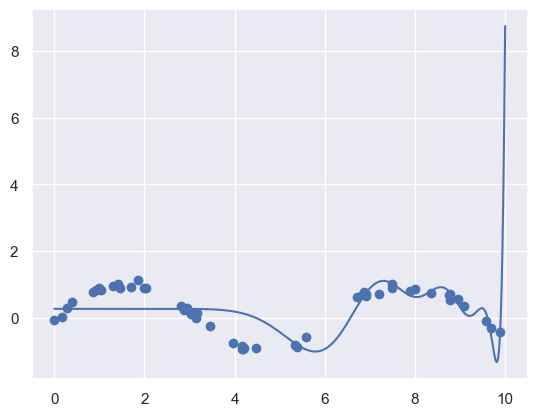

In [121]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)



xfit = np.linspace(0, 10, 1000)


poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

Наша линейная модель с использованием полиномиальных базисных функций 7-го порядка может обеспечить отличное соответствие этим нелинейным данным!

### Гауссовы базисные функции

Конечно, возможны и другие базисные функции.
Например, одним из полезных шаблонов является подбор модели, которая представляет собой не сумму оснований полиномов, а сумму оснований Гаусса.
Результат может выглядеть примерно так, как показано на следующем рисунке:

![](figures/05.06-gaussian-basis.png)
[figure source in Appendix](#Gaussian-Basis)

Заштрихованные области на графике представляют собой масштабированные базисные функции, и при суммировании они воспроизводят гладкую кривую по данным.
Эти базисные функции Гаусса не встроены в Scikit-Learn, но мы можем написать собственный преобразователь, который создаст их, как показано здесь и показано на следующем рисунке (преобразователи Scikit-Learn реализованы как классы Python; чтение исходного кода Scikit-Learn хороший способ увидеть, как они могут быть созданы):

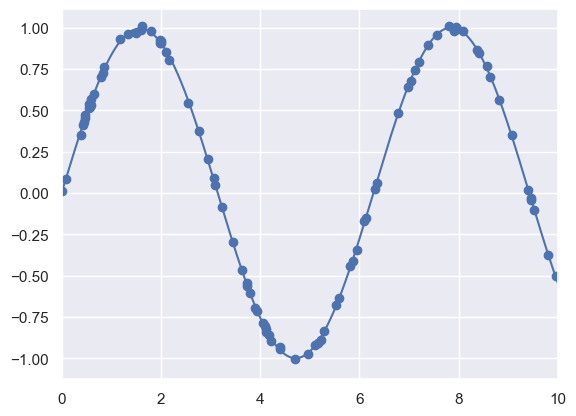

In [93]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

Мы приводим этот пример здесь только для того, чтобы прояснить, что в полиномиальных базисных функциях нет ничего волшебного: если у вас есть какая-то интуиция в процессе генерации ваших данных, которая заставляет вас думать, что тот или иной базис может быть уместным, вы можете использовать их как Что ж.

## Регуляризация

Введение базисных функций в нашу линейную регрессию делает модель намного более гибкой, но также может очень быстро привести к переобучению (см. [Гиперпараметры и проверка модели](05.03-Hyperparameters-and-Model-Validation.ipynb) для обсуждения этого).
Например, если мы выберем слишком много базисных функций Гаусса, мы получим не очень хорошие результаты:

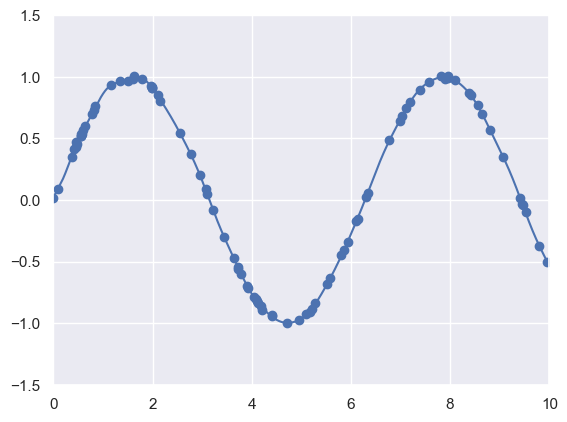

In [97]:
model = make_pipeline(GaussianFeatures(100),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

С данными, спроецированными на 30-мерную основу, модель обладает слишком большой гибкостью и достигает экстремальных значений между точками, где она ограничена данными.
Мы можем увидеть причину этого, если построим коэффициенты базиса Гаусса относительно их местоположения:

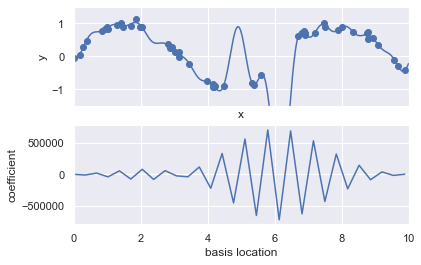

In [46]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

На нижней панели этого рисунка показана амплитуда базисной функции в каждом месте.
Это типичное поведение переобучения, когда базисные функции перекрываются: коэффициенты соседних базисных функций взрываются и компенсируют друг друга.
Мы знаем, что такое поведение проблематично, и было бы неплохо, если бы мы могли явно ограничивать такие всплески в модели, штрафуя большие значения параметров модели.
Такое наказание известно как *урегулирование* и имеет несколько форм.

### Гребневая регрессия (регуляризация $L_2$)

Возможно, наиболее распространенная форма регуляризации известна как *гребенчатая регрессия* или $L_2$ *регуляризация*, иногда также называемая *регуляризацией по Тихонову*.
Это происходит путем штрафования суммы квадратов (2-норм) коэффициентов модели; в этом случае штраф за соответствие модели будет
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$
где $\alpha$ — свободный параметр, контролирующий силу штрафа.
Этот тип штрафной модели встроен в Scikit-Learn с оценщиком «Ridge»:

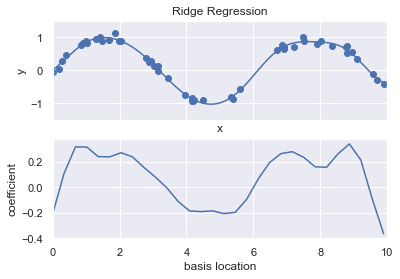

In [47]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

Параметр $\alpha$ по сути является ручкой управления сложностью результирующей модели.
В пределе $\alpha\to 0$ мы восстанавливаем стандартный результат линейной регрессии; в пределе $\alpha\to \infty$ все ответы модели будут подавлены.
Одним из преимуществ гребневой регрессии, в частности, является то, что ее можно вычислить очень эффективно — едва ли при больших вычислительных затратах, чем исходная модель линейной регрессии.

### Лассо-регрессия (регуляризация $L_1$)

Другой очень распространенный тип регуляризации известен как лассо и включает штрафование суммы абсолютных значений (1-норм) коэффициентов регрессии:
$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$
Хотя это концептуально очень похоже на гребневую регрессию, результаты могут неожиданно отличаться: например, из-за геометрических причин лассо-регрессия имеет тенденцию отдавать предпочтение *разреженным моделям*, где это возможно: то есть она предпочтительно устанавливает коэффициенты модели точно равными нулю.

Мы можем увидеть это поведение в дублировании фигуры гребневой регрессии, но с использованием L1-нормализованных коэффициентов:

/home/peleng/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e-03, tolerance: 2.065e-03
  model = cd_fast.enet_coordinate_descent(


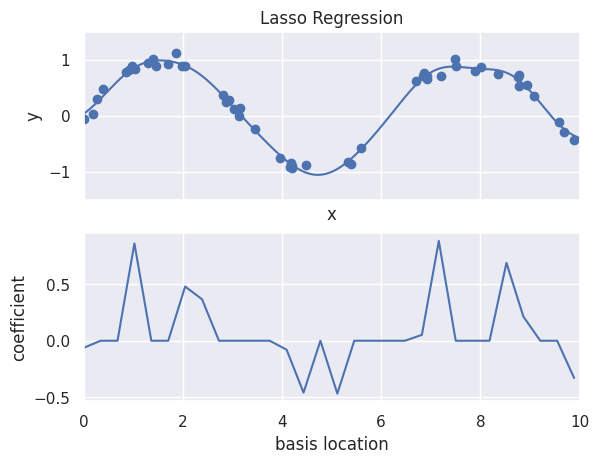

In [13]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

Со штрафом регрессии лассо большинство коэффициентов точно равно нулю, а функциональное поведение моделируется небольшим подмножеством доступных базисных функций.
Как и в случае гребенчатой регуляризации, параметр $\alpha$ настраивает силу штрафа и должен определяться, например, с помощью перекрестной проверки (обратитесь к [Гиперпараметры и проверка модели](05.03-Hyperparameters-and-Model-Validation.ipynb) для обсуждения этого).

## Example: Predicting Bicycle Traffic

В качестве примера давайте посмотрим, можем ли мы предсказать количество поездок на велосипеде по мосту Фремонт в Сиэтле, исходя из погоды, времени года и других факторов.
Мы уже видели эти данные в [Работа с временными рядами](03.11-Работа с временными рядами.ipynb).

В этом разделе мы объединим данные о велосипедах с другим набором данных и попытаемся определить, в какой степени погодные и сезонные факторы — температура, осадки и световой день — влияют на объем велосипедного движения по этому коридору.
К счастью, NOAA предоставляет свои ежедневные [данные метеостанций](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (я использовал идентификатор станции USW00024233), и мы можем легко использовать Pandas для объединить два источника данных.
Мы выполним простую линейную регрессию, чтобы связать информацию о погоде и другую информацию с количеством велосипедов, чтобы оценить, как изменение любого из этих параметров влияет на количество гонщиков в данный день.

В частности, это пример того, как инструменты Scikit-Learn можно использовать в структуре статистического моделирования, в которой предполагается, что параметры модели имеют интерпретируемое значение.
Как обсуждалось ранее, это не стандартный подход в машинном обучении, но такая интерпретация возможна для некоторых моделей.

Начнем с загрузки двух наборов данных, индексируя их по дате.:

In [48]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100 1470k    0 1470k    0     0   378k      0 --:--:--  0:00:03 --:--:--  378k
100 2446k    0 2446k    0     0   399k      0 --:--:--  0:00:06 --:--:--  399k
100 2725k    0 2725k    0     0   444k      0 --:--:--  0:00:06 --:--:--  517k


In [125]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [124]:
import pandas as pd
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)

Далее мы вычислим общий ежедневный велосипедный трафик и поместим его в собственный фрейм данных:

In [127]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

In [4]:
daily

,Total
Date,
2012-10-03,7042.0
2012-10-04,6950.0
2012-10-05,6296.0
2012-10-06,4012.0
2012-10-07,4284.0
...,...
2022-09-26,6374.0
2022-09-27,7344.0
2022-09-28,5812.0


Ранее мы видели, что модели употребления обычно меняются изо дня в день; давайте учтем это в наших данных, добавив двоичные столбцы, указывающие день недели:

In [128]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

Точно так же мы можем ожидать, что водители будут вести себя по-другому в праздничные дни; давайте также добавим индикатор этого:

In [129]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

Мы также можем предположить, что количество часов дневного света повлияет на то, сколько людей едут; давайте воспользуемся стандартным астрономическим расчетом, чтобы добавить эту информацию:

(8.0, 17.0)

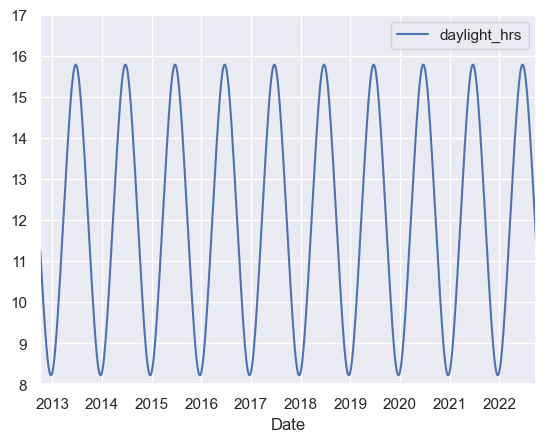

In [130]:
import numpy as np

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

Мы также можем добавить к данным среднюю температуру и общее количество осадков.
В дополнение к дюймам осадков давайте добавим флаг, указывающий, является ли день сухим (нет ли осадков):

In [131]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

Наконец, давайте добавим счетчик, который увеличивается с первого дня и измеряет, сколько лет прошло.
Это позволит нам измерить любое наблюдаемое ежегодное увеличение или уменьшение количества ежедневных пересечений:

In [132]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

Теперь наши данные в порядке, и мы можем взглянуть на них:

In [133]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


Имея это на месте, мы можем выбрать столбцы для использования и подогнать модель линейной регрессии к нашим данным.
Мы установим ``fit_intercept = False``, потому что ежедневные флаги по сути работают как их собственные перехваты для конкретного дня:

In [134]:
# Drop any rows with null values
from sklearn.linear_model import LinearRegression
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

Наконец, мы можем визуально сравнить общий и прогнозируемый велосипедный трафик:

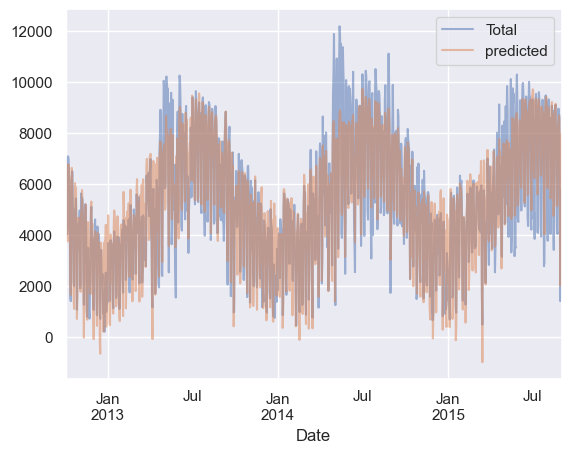

In [135]:
daily[['Total', 'predicted']].plot(alpha=0.5);

Очевидно, что мы упустили некоторые ключевые особенности, особенно в летнее время.
Либо наши характеристики неполны (т. е. люди решают, ехать ли им на работу, основываясь не только на них), либо существуют некоторые нелинейные отношения, которые мы не учли (например, люди меньше ездят как при высоких, так и при низких температурах). ).
Тем не менее, нашего грубого приближения достаточно, чтобы дать нам некоторое представление, и мы можем взглянуть на коэффициенты линейной модели, чтобы оценить, какой вклад каждая функция вносит в ежедневное количество велосипедов:

In [13]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon             1009.765512
Tue             1220.467872
Wed             1185.347283
Thu              964.716230
Fri              355.960691
Sat            -2206.603421
Sun            -2267.134492
holiday        -2374.802762
daylight_hrs     257.703022
PRCP           -1329.669764
dry day         1095.397185
Temp (C)         130.325582
annual            53.885426
dtype: float64

Эти числа трудно интерпретировать без некоторой меры их неопределенности.
Мы можем быстро вычислить эти неопределенности, используя повторную выборку данных при начальной загрузке:

In [14]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

Оценив эти ошибки, давайте снова посмотрим на результаты:

In [15]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon           1010.0  173.0
Tue           1220.0  166.0
Wed           1185.0  166.0
Thu            965.0  170.0
Fri            356.0  162.0
Sat          -2207.0  159.0
Sun          -2267.0  166.0
holiday      -2375.0  326.0
daylight_hrs   258.0   18.0
PRCP         -1330.0  125.0
dry day       1095.0   66.0
Temp (C)       130.0    7.0
annual          54.0   35.0


Сначала мы видим относительно стабильную тенденцию в недельном базовом плане: в будни пассажиров гораздо больше, чем в выходные и праздничные дни.
Мы видим, что на каждый дополнительный час дневного света едет на 129 ± 9 человек больше; повышение температуры на один градус Цельсия побуждает 65 ± 4 человек схватить свой велосипед; сухой день означает, что в среднем на 548 ± 33 больше велосипедистов, а каждый дюйм осадков означает, что еще 665 ± 62 человека оставляют свой велосипед дома.
После того, как все эти эффекты будут учтены, мы увидим скромный прирост на 27 ± 18 новых ежедневных райдеров каждый год.

В нашей модели почти наверняка отсутствует какая-то важная информация. Например, нелинейные эффекты (такие как влияние осадков * и * низкой температуры) и нелинейные тренды в пределах каждой переменной (например, нежелание ездить при очень низких и очень высоких температурах) не могут быть учтены в этой модели.
Кроме того, мы отбросили некоторую более точную информацию (например, разницу между дождливым утром и дождливым днем) и проигнорировали корреляции между днями (например, возможное влияние дождливого вторника на показатели среды или эффект неожиданного солнечного дня после череды дождливых дней).
Все это потенциально интересные эффекты, и теперь у вас есть инструменты, чтобы приступить к их изучению, если хотите!